In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        decoded = self.decoder(x)
        return decoded


In [ ]:
class Encoder_bottleneck(nn.Module):
    def __init__(self, bottleneck_dim):
        super(Encoder_bottleneck, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, bottleneck_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

In [ ]:
class Decoder_bottleneck(nn.Module):
    def __init__(self, bottleneck_dim):
        super(Decoder_bottleneck, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        decoded = self.decoder(x)
        return decoded


In [ ]:
# Function to add Gaussian noise to images
def add_noise(images, sigma):
    noise = torch.randn_like(images) * sigma
    noisy_images = images + noise
    return noisy_images

In [ ]:
# Function to train the model
def train_model(encoder, decoder, criterion, optimizer, train_loader, noise_sigma):
    encoder.train()
    decoder.train()
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.view(-1, 28 * 28)  # Flatten the input images
        noisy_images = add_noise(images, noise_sigma)
        optimizer.zero_grad()
        encoded = encoder(noisy_images)
        outputs = decoder(encoded)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(train_loader.dataset)

In [ ]:
# Function to evaluate the model using SSIM
def evaluate_model(encoder, decoder, test_loader):
    encoder.eval()
    decoder.eval()
    ssim_scores = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.view(-1, 28 * 28)  # Flatten the input images
            encoded = encoder(images)  # Encode original images
            recon_images = decoder(encoded)
            recon_images = recon_images.view(-1, 1, 28, 28)  # Reshape reconstructed images

            # Ensure original and reconstructed images have the same dimensions
            images = images.view(-1, 1, 28, 28)

            for i in range(images.size(0)):
                ssim_score = ssim(images[i].squeeze().numpy(), recon_images[i].squeeze().numpy())
                ssim_scores.append(ssim_score)
    return np.mean(ssim_scores)


In [ ]:
# Function to plot results
def plot_results(x_values, y_values, xlabel, ylabel, title):
    plt.plot(x_values, y_values, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [ ]:
# Parameters
batch_size = 32
learning_rate = 0.001
epochs = 10
sigma_values = [0.1, 0.5, 1.0]
bottleneck_dims = [8, 16, 32]

In [ ]:
# Transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Initialize Encoder and Decoder models
encoder = Encoder()
decoder = Decoder()

In [ ]:
# Initialize loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

# Initialize lists to store SSIM scores
ssim_scores_sigma = []

In [ ]:
for sigma in sigma_values:
  # Train model
  for epoch in range(epochs):
      train_loss = train_model(encoder, decoder, criterion, optimizer, train_loader, sigma)
      print(f"Epoch [{epoch+1}/{epochs}], Sigma: {sigma}, Train Loss: {train_loss:.4f}")

  # Evaluate model
  avg_ssim_sigma = evaluate_model(encoder, decoder, test_loader)
  ssim_scores_sigma.append(avg_ssim_sigma)
  print(f"Average SSIM for Sigma={sigma}: {avg_ssim_sigma:.4f}")

Epoch [1/10], Sigma: 0.1, Train Loss: 0.0109
Epoch [2/10], Sigma: 0.1, Train Loss: 0.0107
Epoch [3/10], Sigma: 0.1, Train Loss: 0.0104
Epoch [4/10], Sigma: 0.1, Train Loss: 0.0102
Epoch [5/10], Sigma: 0.1, Train Loss: 0.0101
Epoch [6/10], Sigma: 0.1, Train Loss: 0.0099
Epoch [7/10], Sigma: 0.1, Train Loss: 0.0098
Epoch [8/10], Sigma: 0.1, Train Loss: 0.0097
Epoch [9/10], Sigma: 0.1, Train Loss: 0.0096
Epoch [10/10], Sigma: 0.1, Train Loss: 0.0095
Average SSIM for Sigma=0.1: 0.9158
Epoch [1/10], Sigma: 0.5, Train Loss: 0.0191
Epoch [2/10], Sigma: 0.5, Train Loss: 0.0179
Epoch [3/10], Sigma: 0.5, Train Loss: 0.0176
Epoch [4/10], Sigma: 0.5, Train Loss: 0.0174
Epoch [5/10], Sigma: 0.5, Train Loss: 0.0172
Epoch [6/10], Sigma: 0.5, Train Loss: 0.0171
Epoch [7/10], Sigma: 0.5, Train Loss: 0.0170
Epoch [8/10], Sigma: 0.5, Train Loss: 0.0170
Epoch [9/10], Sigma: 0.5, Train Loss: 0.0168
Epoch [10/10], Sigma: 0.5, Train Loss: 0.0168
Average SSIM for Sigma=0.5: 0.8810
Epoch [1/10], Sigma: 1.0, Tr

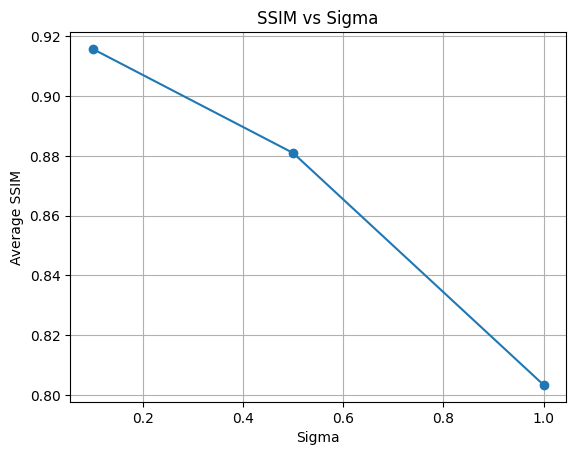

In [ ]:
plot_results(sigma_values, ssim_scores_sigma, 'Sigma', 'Average SSIM', 'SSIM vs Sigma')

**Observations**


*   For Sigma = 0.1: Train Loss: 0.0095, Average SSIM: 0.9158
*   For Sigma = 0.5: Train Loss: 0.0168, Average SSIM: 0.8810
*   For Sigma = 1.0: Train Loss: 0.0279, Average SSIM: 0.8034
*   The SSIM metric measures the structural similarity between the two images. As the sigma value increases which indicates the higher levels of Gaussian noise, the input images become more distorted and less similar to the original clean images. As a result, the reconstructed images produced by the model also become less similar to the originals, resulting in lower SSIM scores.





In [ ]:
ssim_scores_bottleneck = []

for bottleneck_dim in bottleneck_dims:
  # Initialize Encoder and Decoder models
  encoder = Encoder_bottleneck(bottleneck_dim)
  decoder = Decoder_bottleneck(bottleneck_dim)

  # Initialize loss function and optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

  # Train model
  for epoch in range(epochs):
      train_loss = train_model(encoder, decoder, criterion, optimizer, train_loader, sigma)
      print(f"Epoch [{epoch+1}/{epochs}], Bottleneck Dimension: {bottleneck_dim}, Train Loss: {train_loss:.4f}")

  # Evaluate model
  avg_ssim_bottleneck = evaluate_model(encoder, decoder, test_loader)
  ssim_scores_bottleneck.append(avg_ssim_bottleneck)
  print(f"Average SSIM for Bottleneck Dimension={bottleneck_dim}: {avg_ssim_bottleneck:.4f}")


Epoch [1/10], Bottleneck Dimension: 8, Train Loss: 0.0560
Epoch [2/10], Bottleneck Dimension: 8, Train Loss: 0.0407
Epoch [3/10], Bottleneck Dimension: 8, Train Loss: 0.0375
Epoch [4/10], Bottleneck Dimension: 8, Train Loss: 0.0360
Epoch [5/10], Bottleneck Dimension: 8, Train Loss: 0.0352
Epoch [6/10], Bottleneck Dimension: 8, Train Loss: 0.0344
Epoch [7/10], Bottleneck Dimension: 8, Train Loss: 0.0339
Epoch [8/10], Bottleneck Dimension: 8, Train Loss: 0.0334
Epoch [9/10], Bottleneck Dimension: 8, Train Loss: 0.0331
Epoch [10/10], Bottleneck Dimension: 8, Train Loss: 0.0328
Average SSIM for Bottleneck Dimension=8: 0.7213
Epoch [1/10], Bottleneck Dimension: 16, Train Loss: 0.0547
Epoch [2/10], Bottleneck Dimension: 16, Train Loss: 0.0405
Epoch [3/10], Bottleneck Dimension: 16, Train Loss: 0.0378
Epoch [4/10], Bottleneck Dimension: 16, Train Loss: 0.0363
Epoch [5/10], Bottleneck Dimension: 16, Train Loss: 0.0351
Epoch [6/10], Bottleneck Dimension: 16, Train Loss: 0.0343
Epoch [7/10], Bot

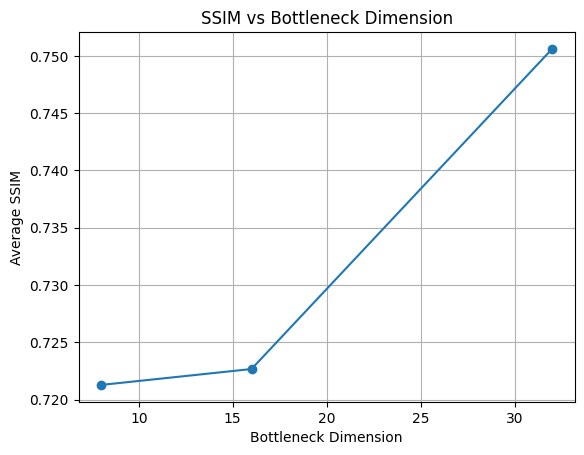

In [ ]:
# Plot results
plot_results(bottleneck_dims, ssim_scores_bottleneck, 'Bottleneck Dimension', 'Average SSIM', 'SSIM vs Bottleneck Dimension')

**Observations:**



*   For bottleneck dim = 8: Train Loss: 0.0328, Average SSIM: 0.7213
*   For bottleneck dim = 16: Train Loss: 0.0322, Average SSIM: 0.7227
*   For bottleneck dim = 32: Train Loss: 0.0307, Average SSIM: 0.7506
*   The bottleneck dimension affects the capacity of the model to capture and represent the essential features of the input data. As the bottleneck dimension increases, the model becomes more capable of reconstructing the input data accurately. Thus it can be we observed that the average SSIM score increases with increasing bottleneck dimension. This indicates that the reconstructed images become more similar to the original images as the bottleneck dimension increases.



